In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pickle

In [8]:
from keras.models import Model
from keras import layers
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.utils import plot_model

In [9]:
train = pd.read_csv('train.csv', low_memory=False)
train_id = pd.read_csv('train.csv', low_memory=False, usecols = ['id'])
test_id  = pd.read_csv('test.csv', low_memory=False, usecols = ['id'])
train_target = pd.read_csv('train.csv', usecols = ['target'])
embedding_matrix = pd.read_csv('data_process/embedding_matrix_200d').values

In [10]:
totaldata = pd.read_csv('data_process/totaldata.csv',low_memory=False)

In [11]:
totaldata.shape

(10876, 57)

In [12]:
totaldata.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'keyword_metric',
       'domain_metric_mean', 'domain_metric_std', 'domain_metric_max',
       'domain_metric_min', 'textsize', 'punctuation_count', 'word_mean_len',
       'haslocacion', 'word_count', 'upper_count', 'white_count', 'url_count',
       'hashtag_count', 'mention_count', 'PRP$', 'NNS', 'VBP', 'DT', 'NNP',
       'IN', 'NN', 'PRP', 'VBD', 'TO', 'VB', 'VBG', 'VBN', 'JJ', 'CC', 'RB',
       'VBZ', 'MD', 'EX', 'CD', 'WP', 'RP', 'NNPS', 'JJR', 'WRB', 'JJS', 'WDT',
       'RBR', 'RBS', 'FW', 'PDT', 'POS', 'UH', 'SYM', 'WP$', '''',
       'question_count'],
      dtype='object')

In [13]:
del totaldata['text']
del totaldata['keyword']
del totaldata['location']
del totaldata['id']

In [14]:
train = totaldata[totaldata['target'] != 2]
test = totaldata[totaldata['target'] == 2]

In [15]:
del train['target']
del test['target']

In [16]:
f_num = train.shape[1]

In [17]:
num_words = embedding_matrix.shape[0]
e_num = embedding_matrix.shape[1]

In [18]:
test.isna().any().any(), train.isna().any().any()

(False, False)

In [19]:
totaldata.columns

Index(['target', 'keyword_metric', 'domain_metric_mean', 'domain_metric_std',
       'domain_metric_max', 'domain_metric_min', 'textsize',
       'punctuation_count', 'word_mean_len', 'haslocacion', 'word_count',
       'upper_count', 'white_count', 'url_count', 'hashtag_count',
       'mention_count', 'PRP$', 'NNS', 'VBP', 'DT', 'NNP', 'IN', 'NN', 'PRP',
       'VBD', 'TO', 'VB', 'VBG', 'VBN', 'JJ', 'CC', 'RB', 'VBZ', 'MD', 'EX',
       'CD', 'WP', 'RP', 'NNPS', 'JJR', 'WRB', 'JJS', 'WDT', 'RBR', 'RBS',
       'FW', 'PDT', 'POS', 'UH', 'SYM', 'WP$', '''', 'question_count'],
      dtype='object')

In [20]:
pickle_in = open("data_process/tweet_pad_200d.pickle","rb")
tweet_pad = pickle.load(pickle_in)

In [21]:
embedd_train =tweet_pad[:train.shape[0]]
embedd_test=tweet_pad[train.shape[0]:]

In [23]:
embedd_train.shape, embedd_test.shape, train.shape, test.shape

((7613, 100), (3263, 100), (7613, 52), (3263, 52))

In [24]:
embedd_test = pd.DataFrame(embedd_test)
embedd_train = pd.DataFrame(embedd_train)

In [25]:
scaled = MinMaxScaler()
train = pd.DataFrame(scaled.fit_transform(train), columns= train.columns)
test = pd.DataFrame(scaled.fit_transform(test), columns= test.columns)

In [26]:
train.columns

Index(['keyword_metric', 'domain_metric_mean', 'domain_metric_std',
       'domain_metric_max', 'domain_metric_min', 'textsize',
       'punctuation_count', 'word_mean_len', 'haslocacion', 'word_count',
       'upper_count', 'white_count', 'url_count', 'hashtag_count',
       'mention_count', 'PRP$', 'NNS', 'VBP', 'DT', 'NNP', 'IN', 'NN', 'PRP',
       'VBD', 'TO', 'VB', 'VBG', 'VBN', 'JJ', 'CC', 'RB', 'VBZ', 'MD', 'EX',
       'CD', 'WP', 'RP', 'NNPS', 'JJR', 'WRB', 'JJS', 'WDT', 'RBR', 'RBS',
       'FW', 'PDT', 'POS', 'UH', 'SYM', 'WP$', '''', 'question_count'],
      dtype='object')

In [27]:
test = pd.concat([test,embedd_test],axis=1)
train = pd.concat([train,embedd_train],axis=1)

In [23]:
train.isna().any().any() , test.isna().any().any()

(False, False)

In [72]:
#features_input = layers.Input(shape=(f_num,), name="features")
#x = layers.Dense(128, activation='relu')(features_input)
#eatures_output = layers.Dropout(0.5)(x)

emb_input = layers.Input(shape=(None,), name="embedd")
x = layers.Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=e_num)(emb_input)
x = layers.Conv1D(256 , 5 , activation = 'relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Conv1D(256 , 5 , activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
emb_output = layers.Dropout(0.5)(x)

#x = layers.concatenate([features_output, emb_output])
x = layers.Dense(128,activation='relu')(emb_output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32,activation='relu')(x)
x = layers.Dropout(0.5)(x)
conv1d = layers.Dense(1, activation='sigmoid')(x)

model4 = Model(
    inputs=[emb_input],
    outputs=[conv1d],
)
#optimzer = SGD(learning_rate=1e-5, momentum=0.8)
optimzer=Adam(learning_rate=1e-5)
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimzer,
    metrics=['accuracy']
)

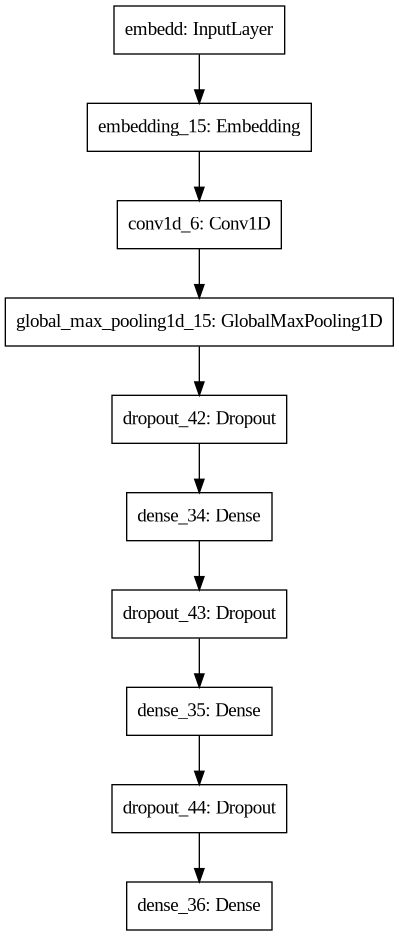

In [73]:
plot_model(model4, "my_first_model.png")

In [32]:
#model4.summary()

In [35]:
#early_stop = EarlyStopping(
#    monitor='val_accuracy',
#    patience=6)

In [46]:
history=model4.fit( 
    {"features": train.values[:,:f_num], "embedd": train.values[:,f_num:]},
    train_target.values,
    batch_size=10,
    epochs=10,
    validation_split = 0.3,
    verbose = 1
)

Epoch 1/10
609/609 [==============================] - 128s 211ms/step - loss: 6.0553 - accuracy: 0.4484 - val_loss: 5.6619 - val_accuracy: 0.5384
Epoch 2/10
609/609 [==============================] - 125s 205ms/step - loss: 5.5824 - accuracy: 0.5205 - val_loss: 5.2746 - val_accuracy: 0.6743
Epoch 3/10
609/609 [==============================] - 122s 201ms/step - loss: 5.1899 - accuracy: 0.5888 - val_loss: 4.9245 - val_accuracy: 0.7498
Epoch 4/10
609/609 [==============================] - 122s 200ms/step - loss: 4.8410 - accuracy: 0.6360 - val_loss: 4.5993 - val_accuracy: 0.7551
Epoch 5/10
609/609 [==============================] - 114s 187ms/step - loss: 4.5231 - accuracy: 0.6729 - val_loss: 4.2941 - val_accuracy: 0.7676
Epoch 6/10
609/609 [==============================] - 115s 188ms/step - loss: 4.2263 - accuracy: 0.7018 - val_loss: 4.0105 - val_accuracy: 0.7741
Epoch 7/10
609/609 [==============================] - 116s 190ms/step - loss: 3.9631 - accuracy: 0.7100 - val_loss: 3.7501 -

In [47]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

In [42]:
f_num

52

In [43]:
test.values[:,f_num:].shape

(3263, 100)

In [51]:
#predict = model4.predict([test.values[:,:f_num],embedd_test.values])
predict = model4.predict(embedd_test.values)
predict=np.round(predict).astype(int).reshape(3263)
submit = pd.read_csv('test.csv', usecols= ['id'])
submit['target'] = predict
submit.to_csv('submits/200dTw-BRNN.csv',index=False)

In [52]:
submit['target'].value_counts()

0    2072
1    1191
Name: target, dtype: int64